<a href="https://colab.research.google.com/github/HJBJalaly/DLeeg/blob/master/best%20channel/Mine/2Ch_Base_Normal_Orthogonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mne

In [0]:
'''
2 channel :  Cz (index =10), Oz (index =61),

layers: 3 conv2D(3,3) & maxpooling(2,2)
epoch: 20 
batch size: 20

test acc: 0.7886
test loss: 0.6802

'''


import matplotlib
from matplotlib import pyplot as plt
import numpy as np


import math
import random
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
#from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)


2 channel :  Cz (index =10), Oz (index =61),

layers: 3 conv2D(3,3) & maxpooling(2,2)
epoch: 20 
batch size: 20

test acc: 0.7886
test loss: 0.6802




In [0]:
# Parameters:
subject_number=20
task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
sample_shift = 4 #step len
window_len= 20
list_channel = [10,61] # channel = Cz, Oz

# Channel Indexes:
#   Fp1,21
#   Fp2,23
#   F7,29
#   F3,31
#   Fz,33
#   F4,35
#   F8,36
#   T7,40
#   C3,8
#   Cz,10
#   C4,12
#   T8,41
#   P7,46
#   P3,48
#   Pz,50
#   P4,52
#   P8,54
#   O1,60
#   Oz,61
#   O2,62

#   T9,42
#   T10,43


In [0]:
# load dataset in array
list_raw_fnames = [[0]*2]*subject_number
for x in range(subject_number):
    list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,[1,2])

list_rawdata1 = np.zeros((subject_number,2), dtype='object')
list_rawdata = np.zeros((subject_number,2), dtype='object')

for i in range(subject_number):
    for j in range(2):
        list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)
       

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extr

In [0]:
# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec) / sample_shift) +1 - window_len +1
test_start_index=subject_img_number - math.floor(subject_img_number/4) 

train_number =  test_start_index 
test_number = subject_img_number - test_start_index
print("Train sample:",train_number)
print("Test sample:",test_number)

ch_number = len(list_channel)

train_img = np.zeros((train_number*subject_number, ch_number, window_len + 1, 160), dtype = float)
train_label =[]

test_img = np.zeros((test_number*subject_number, ch_number, window_len, 160), dtype = float)
test_label =[]

print("train image dims:",train_img.shape)

Train sample: 1757
Test sample: 585
train image dims: (35140, 2, 21, 160)


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
# Make a copy of main data
list_rawdataTemp=list_rawdata.copy()

for s in range(subject_number):
    
    DataAllChannelsRaw, times =list_rawdataTemp[s][0][:64,:9600]
    
    
    # Extrac Channel T9 as Baseline
    DataChannelT9Raw =DataAllChannelsRaw[42]# Ch T9
    
    
    # Extract Selected Channles
    DataChannelsRaw=np.zeros((len(list_channel),times.size),dtype = float)
    for i in range(len(list_channel)):
      DataChannelsRaw[i]=DataAllChannelsRaw[list_channel[i]]
    
    # Remove BaseLine
    DataChannelsBase=np.zeros((len(list_channel),times.size),dtype = float)
    for i in range(len(list_channel)):
      DataChannelsBase[i]=DataChannelsRaw[i]#-DataChannelT9Raw
      
    
    # find min/max per channel
    ch_max =[]
    ch_min =[]
    for i in range(len(list_channel)):
      #print(ch)  
      ch_max = np.append(ch_max, max(DataChannelsBase[i])) # max for each cannel
      ch_min = np.append(ch_min, min(DataChannelsBase[i])) # min for each cannel
    
    # Normalize Channels
    DataChannelsNormal=np.zeros((len(list_channel),times.size),dtype = float)
    for i in range(len(list_channel)):
        #print(i)
        DataChannelsNormal[i]=normalize_channel_data(DataChannelsBase[i].copy(), i, ch_min, ch_max)
    
    
    
    # Orthogonal Channel
    DataChannelsOrt=np.zeros((len(list_channel),times.size),dtype = float)
    DataChannelsOrt[0]=DataChannelsNormal[0]
    DataChannelsOrt[1]=DataChannelsNormal[1]-ProjectionVector(DataChannelsNormal[0],DataChannelsNormal[1])
    
    
    
    
    for j in range (subject_img_number):
        for i in range(len(list_channel)): # فقط کانال های با اندیس مشخص را دربرمیگیرد
            for z in range (window_len):
                #rawdataChannels, times =list_rawdata[s][0][index, (j+z)*sample_shift:sampel_number_per_sec+(j+z)*sample_shift]
                ExtractedData=DataChannelsOrt[i,0+(j+z)*sample_shift:sampel_number_per_sec+(j+z)*sample_shift]


                # normalize method
                #rawdataChannels = normalize_channel_data(rawdataChannels, i, ch_min, ch_max)
                if j <test_start_index :
                    train_img[s*train_number + j][i][z] = ExtractedData
                    if z==window_len-1 :
                        train_img[s*train_number + j][i][z+1] = s
                      
                      
                else:
                     test_img[s*test_number + j - test_start_index][i][z] = ExtractedData
            #i+=1            
                    
              
        if j >=test_start_index :
            test_label = np.append(test_label, (s))

In [0]:

# # Make a copy of main data
# list_rawdataTemp=list_rawdata.copy()

# for s in range(subject_number):
    
#     # find min/max per channel
#     ch_max =[]
#     ch_min =[]
#     for ch in list_channel:
#       rawdataChannels_t, times_t =list_rawdataTemp[s][0][ch,:9600]
#       #print(rawdataChannels_t)
#       ch_max = np.append(ch_max, max(rawdataChannels_t[0])) # max for each cannel
#       ch_min = np.append(ch_min, min(rawdataChannels_t[0])) # min for each cannel
    
#     # Normalize Channels
#     DataChannelsNormal=np.zeros((len(list_channel),times.size),dtype = float)
#     for i in range(len(list_channel)):
#         DataChannelsNormal[i]=normalize_channel_data(DataChannelsRaw_t[i], i, ch_min, ch_max)
    
    
#     for j in range (subject_img_number):
#         i = 0
#         for index in list_channel: # فقط کانال های با اندیس مشخص را دربرمیگیرد
            
#             for z in range (window_len):
#                 rawdataChannels, times =list_rawdata[s][0][index, (j+z)*sample_shift:sampel_number_per_sec+(j+z)*sample_shift]

#                       # normalize method
#                 rawdataChannels = normalize_channel_data(rawdataChannels, i, ch_min, ch_max)
#                 if j <test_start_index :
#                     train_img[s*train_number + j][i][z] = rawdataChannels
#                     if z==window_len-1 :
#                       train_img[s*train_number + j][i][z+1] = s
                      
                      
#                 else:
#                     test_img[s*test_number + j - test_start_index][i][z] = rawdataChannels
#             i+=1            
                    
              
#         if j >=test_start_index :
#           test_label = np.append(test_label, (s))

In [0]:
#shuffle train img array
train_img_shuffle = train_img.copy()

np.random.shuffle(train_img_shuffle)


train_img_2 = np.zeros((train_number*subject_number, ch_number, window_len, 160), dtype = float)

# img label 
train_img_shuffle_len =len(train_img_shuffle)
for i in range(train_img_shuffle_len):
    train_label = np.append(train_label, (train_img_shuffle[i][0][window_len][0] ))
    for j in range (ch_number):
        train_img_2[i][j] = np.delete(train_img_shuffle[i][j], window_len, axis=0)

In [0]:
# Create Model
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers

train_label = to_categorical(train_label, subject_number)
test_label = to_categorical(test_label, subject_number)

x_train =train_img_2[:20000]
y_train =train_label[:20000]

x_valid =train_img_2[20000:]
y_valid =train_label[20000:]


model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Flatten())
print(model.output.shape)
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
print(model.output.shape)
model.add(layers.Dense(subject_number, activation = 'softmax'))
print(model.output.shape)

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

Using TensorFlow backend.







(?, 64, 20, 160)

(?, 32, 10, 160)
(?, 30, 8, 128)
(?, 15, 4, 128)
(?, 13, 2, 256)
(?, ?)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 512)
(?, 20)



In [0]:
# Training
history = model.fit(
        x_train,
        y_train,
        epochs = 20,
        batch_size = 20,
        validation_data = (x_valid, y_valid)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 20000 samples, validate on 15140 samples
Epoch 1/20
20000/20000 [==============================] - 12s 607us/step - loss: 2.3376 - acc: 0.2676 - val_loss: 1.5539 - val_acc: 0.5311
Epoch 2/20
20000/20000 [==============================] - 10s 489us/step - loss: 1.3559 - acc: 0.5429 - val_loss: 0.9335 - val_acc: 0.6874
Epoch 3/20
20000/20000 [==============================] - 10s 491us/step - loss: 0.9388 - acc: 0.6696 - val_loss: 0.6168 - val_acc: 0.7810
Epoch 4/20
20000/20000 [==============================] - 10s 489us/step - loss: 0.7157 - acc: 0.7460 - val_loss: 0.4686 - val_acc: 0.8431
Epoch 5/20
20000/20000 [==============================] - 10s 488us/step - loss: 0.5842 - acc: 0.7928 - val_loss: 0.5342 - val_acc: 0.8045
Epoch 6/20
20000/20000 [==============================] - 10s 487us/step - loss: 0.4887 - acc: 0.8291 - val_loss: 0.3282 - val_acc: 0.8868
Epoch 7/20
20000/20000

In [0]:
model.evaluate(test_img, test_label)


11700/11700 [==============================] - 1s 125us/step


[0.2710713369599563, 0.9176068376068376]

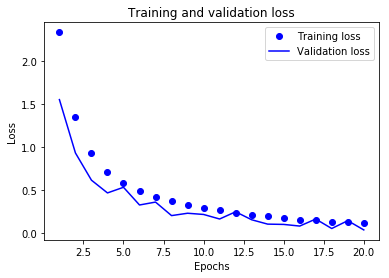

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history 

loss_values = history_dict ['loss'] 

val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)



plt.plot(epochs, loss_values, 'bo', label='Training loss') 

plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 

plt.title('Training and validation loss') 

plt.xlabel('Epochs') 

plt.ylabel('Loss') 

plt.legend()

plt.show()

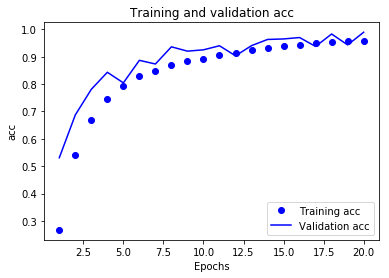

In [0]:
history_dict = history.history 

acc_values = history_dict ['acc'] 

val_acc_values = history_dict['val_acc']



plt.plot(epochs, acc_values, 'bo', label='Training acc') 

plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 

plt.title('Training and validation acc') 

plt.xlabel('Epochs') 

plt.ylabel('acc') 

plt.legend()

plt.show()